# **Livrable 2 – Modélisation du Time-Dependent Vehicle Routing Problem (TDVRP)** 
### Projet ADEME – Mobilité Multimodale Intelligente  
**Équipe :** CesiCDP – Groupe de Louka, Evan, Mael, Hugo  
**Date :** Octobre 2025  
---



## 1. Introduction et Contexte

Depuis les années 90, il y a eu une prise de conscience mondiale de la nécessité de réduire la consommation d'énergie et les émissions de gaz à effet de serre. Les premiers engagements sont apparus lors du **Protocole de Kyoto (1997)**, suivi d'autres plus ambitieux comme la **division par 4 des émissions d’ici 2050 en France**.  

Dans ce contexte, **l’ADEME (Agence de l’Environnement et de la Maîtrise de l’Énergie)** a lancé un appel à manifestation d’intérêt pour promouvoir des **solutions de mobilité innovantes** et plus écologiques.  

Notre équipe **CesiCDP** s’inscrit dans cette démarche à travers une étude sur la **mobilité multimodale intelligente**. Nous avons choisi de nous concentrer sur l’**optimisation des tournées de livraison**, un enjeu central de la logistique moderne.  

Nous modélisons ici un problème de **gestion de tournées (Vehicle Routing Problem - VRP)** en intégrant une **contrainte de trafic dynamique**, pour mieux représenter les conditions de circulation réelles. Notre flotte de véhicules est **thermique et homogène**, ce qui accentue l’importance de la réduction du temps de trajet et de la consommation de carburant.


## 2. Choix de la Méthode : Le Recuit Simulé (SA)

Pour résoudre ce problème, nous avons choisi une **métaheuristique : l'Algorithme du Recuit Simulé (Simulated Annealing)**.

Ce choix est motivé par la nature du problème :

1.  **Problème NP-difficile :** Le VRP (et à plus forte raison le TDVRP) est un problème "NP-difficile". Il est **informatiquement impossible de trouver la solution optimale garantie** en un temps raisonnable pour une instance de 200 clients. Nous devons donc nous tourner vers des méthodes d'approximation.
2.  **Évitement des Minimums Locaux :** Une heuristique simple (comme une "descente") améliorerait la solution en n'acceptant que les "voisins" (solutions légèrement modifiées) qui sont meilleurs. Elle se retrouverait cependant très vite "coincée" dans un **minimum local** : une solution qui *semble* bonne, mais qui n'est pas la meilleure.
3.  **Force du Recuit Simulé :** Le SA surmonte ce problème. Grâce à sa composante aléatoire (`random.random() < math.exp(-delta_cout / temp)`), il s'autorise à **accepter temporairement de moins bonnes solutions**. Cette capacité à "dégrader" la solution lui permet de s'échapper des minimums locaux et d'explorer plus largement l'espace de recherche.
4.  **Flexibilité face aux Contraintes :** Notre contrainte de trafic (`GestionnaireTempsTrajet`) rend le coût d'une tournée non linéaire et complexe. Le Recuit Simulé est parfaitement adapté à cela : il n'a pas besoin de "comprendre" la contrainte, il lui suffit d'évaluer le coût final de la solution (via `calculer_cout`) pour prendre ses décisions.

## 3. Modélisation : Objectif et Contraintes

Notre modèle, implémenté dans le code, vise à optimiser les tournées en respectant un ensemble de règles strictes.

### Objectif : Minimiser le "Makespan"

L'objectif de notre algorithme n'est pas de minimiser la distance totale, mais de **minimiser l'heure de retour du dernier véhicule au dépôt** (`self.cout = temps_retour_max`). C'est un objectif logistique classique (minimisation du "makespan"), qui vise à ce que tous les chauffeurs terminent leur journée le plus tôt possible.

### Contraintes de Validité

Pour qu'une solution soit considérée comme "valide" (coût fini), elle doit respecter deux contraintes majeures :

1.  **Contrainte de Capacité :** La somme des demandes de tous les clients d'une même tournée ne doit jamais dépasser la capacité maximale du véhicule (`if charge_actuelle > instance.capacite_vehicule:`).
2.  **Contrainte de Complétude :** *Tous* les clients listés dans l'instance doivent être servis, et ce, une seule fois (`if len(clients_servis) != len(instance.ids_clients):`).

Si l'une de ces contraintes est violée, la solution est jugée **invalide** et se voit assigner un **coût infini** (`float('inf')`).

### Contrainte Principale : Le Trafic (TDVRP)

La complexité de notre modèle vient de la gestion du temps. Le temps de trajet entre deux points n'est pas constant : il dépend de l'heure de départ (`temps_actuel`) et d'un multiplicateur de trafic. Le temps s'accumule donc de manière dynamique tout au long de la tournée.

- De 0h00 (0 min) à 7h59 : le trafic est normal (multiplicateur x1.0).

- De 8h00 (480 min) à 9h59 : c'est la pointe du matin (multiplicateur x1.8). Les trajets prennent 80% plus de temps.

- De 10h00 (600 min) à 15h59 : c'est creux (multiplicateur x1.2).

- De 16h00 (960 min) à 17h59 : c'est la pointe du soir (multiplicateur x2.0). Les trajets prennent le double du temps.

- À partir de 18h00 (1080 min) : le trafic redevient normal (x1.0).

## 4. Implémentation du Modèle

### 4.1. Imports
Ce premier bloc de code importe toutes les bibliothèques nécessaires au projet : `openpyxl` et `pandas` pour la manipulation des fichiers Excel, `numpy` pour les calculs matriciels (distances), `math` et `random` pour l'algorithme de Recuit Simulé, `copy` pour la gestion des solutions, et `time` / `pathlib` pour la gestion du temps et des fichiers. Nous ajoutons également `matplotlib` et `seaborn` pour les graphiques.

In [1]:
# --- Imports Nécessaires --- 
import openpyxl
import pandas as pd
import numpy as np
import math
import random
import copy
import time
from pathlib import Path

# --- Imports pour les graphiques ---
import matplotlib.pyplot as plt
import seaborn as sns

### 4.2. Générateur d'Instances
Cette fonction utilitaire `generer_et_sauvegarder_instance` est responsable de la création de problèmes de test. Elle génère des coordonnées, des demandes et des fichiers de configuration aléatoires (en nommant le dépôt "Paris"), puis les sauvegarde dans un fichier Excel structuré.

In [2]:
def generer_et_sauvegarder_instance(nb_clients, capacite_vehicule, nb_vehicules, dossier_sortie, nom_fichier_base):
    """
    Génère une instance VRP avec des clients aléatoires et la sauvegarde
    dans un fichier Excel compatible avec le DataLoader.
    """
    nom_fichier = dossier_sortie / f"{nom_fichier_base}_{nb_clients}_clients.xlsx"
    #print(f"Génération d'une instance -> '{nom_fichier}'...") # Commenté pour un affichage plus propre
    ids = list(range(1, nb_clients + 2))
    depot_id = 1
    coords_x = np.random.randint(0, 101, size=nb_clients + 1)
    coords_y = np.random.randint(0, 101, size=nb_clients + 1)
    noms = [f"Client-{i}" for i in ids]
    noms[ids.index(depot_id)] = "Paris"
    df_coords = pd.DataFrame({
        'ID': ids, 'X': coords_x, 'Y': coords_y, 'Nom': noms,
        'info_supp': ['(dépôt)'] + [f'client {i-1}' for i in range(2, nb_clients + 2)]
    })
    demandes = np.random.randint(5, 21, size=nb_clients + 1)
    demandes[ids.index(depot_id)] = 0
    df_demandes = pd.DataFrame({
        'ID': ids, 'Demande': demandes,
        'info_supp': ['le dépôt n\'a aucune commande'] + [f'le client {i-1} commande {demandes[i-1]} unités' for i in range(2, nb_clients + 2)]
    })
    df_config = pd.DataFrame({
        'Propriete': ['CapaciteVehicule', 'NombreVehicules', 'DepotID'],
        'Valeur': [capacite_vehicule, nb_vehicules, depot_id],
        'info_supp': ['Capacite Max du véhicule', 'Nb de véhicules disponibles', 'ID du point de départ']
    })
    with pd.ExcelWriter(nom_fichier, engine='openpyxl') as writer:
        df_coords.to_excel(writer, sheet_name='Coordonnees', index=False)
        df_demandes.to_excel(writer, sheet_name='Demandes', index=False)
        df_config.to_excel(writer, sheet_name='Config', index=False)
    return nom_fichier

### 4.3. Classes de Données (Modèle TDVRP)
Ce bloc contient les classes principales qui modélisent notre problème. `InstanceVRP` stocke toutes les données (capacité, demandes, coordonnées) et précalcule la matrice de distance. `GestionnaireTempsTrajet` implémente la logique de trafic (TDVRP). `Solution` représente un ensemble de tournées et contient la fonction `calculer_cout`, le cœur de notre modèle, qui évalue la validité (capacité, complétude) et le coût (makespan) d'une solution.

In [3]:
class GestionnaireTempsTrajet:
    """Calcule le temps de trajet en fonction de l'heure et du trafic."""
    def __init__(self, matrice_distances_base, tranches_horaires_minutes, multiplicateurs):
        self.temps_trajet_base = matrice_distances_base
        self.tranches_horaires = tranches_horaires_minutes
        self.multiplicateurs = multiplicateurs
    def calculer_temps_trajet_et_arrivee(self, id_noeud_depart, id_noeud_arrivee, temps_depart_minutes):
        multiplicateur_actuel = 1.0
        for i in range(len(self.tranches_horaires)):
            if temps_depart_minutes >= self.tranches_horaires[i]:
                multiplicateur_actuel = self.multiplicateurs[i]
            else:
                break
        temps_base = self.temps_trajet_base[id_noeud_depart, id_noeud_arrivee]
        temps_trajet_reel = temps_base * multiplicateur_actuel
        temps_arrivee_minutes = temps_depart_minutes + temps_trajet_reel
        return temps_trajet_reel, temps_arrivee_minutes

class InstanceVRP:
    """Stocke toutes les données d'un problème VRP."""
    def __init__(self, config, coords, demandes, noms):
        self.capacite_vehicule = config['CapaciteVehicule']
        self.nb_vehicules = config['NombreVehicules']
        self.id_depot = config['DepotID']
        self.coords_noeuds = coords
        self.demandes_clients = demandes
        self.noms_noeuds = noms
        self.ids_noeuds = sorted(list(self.coords_noeuds.keys()))
        self.nb_noeuds = len(self.ids_noeuds)
        self.ids_clients = [idx for idx in self.ids_noeuds if idx != self.id_depot]
        self.id_vers_idx = {id_noeud: i for i, id_noeud in enumerate(self.ids_noeuds)}
        self.matrice_distances = self._calculer_matrice_distances_euclidienne()
    def _calculer_matrice_distances_euclidienne(self):
        matrice = np.zeros((self.nb_noeuds, self.nb_noeuds))
        for id1 in self.ids_noeuds:
            for id2 in self.ids_noeuds:
                idx1, idx2 = self.id_vers_idx[id1], self.id_vers_idx[id2]
                p1, p2 = self.coords_noeuds[id1], self.coords_noeuds[id2]
                matrice[idx1, idx2] = np.linalg.norm(np.array(p1) - np.array(p2))
        return matrice

class Solution:
    """Représente une solution VRP : une liste de tournées et son coût."""
    def __init__(self, tournees, cout=float('inf')):
        self.tournees = tournees
        self.cout = cout
        self.temps_calcul = 0
    def calculer_cout(self, instance, gestionnaire_temps):
        temps_retour_max = 0; solution_valide = True; clients_servis = set()
        for tournee in self.tournees:
            temps_actuel = 0.0; charge_actuelle = 0; id_noeud_actuel = instance.id_depot
            for id_noeud_suivant in tournee[1:]:
                if id_noeud_suivant != instance.id_depot: clients_servis.add(id_noeud_suivant)
                charge_actuelle += instance.demandes_clients.get(id_noeud_suivant, 0)
                if charge_actuelle > instance.capacite_vehicule: solution_valide = False; break
                idx_actuel, idx_suivant = instance.id_vers_idx[id_noeud_actuel], instance.id_vers_idx[id_noeud_suivant]
                _, temps_arrivee = gestionnaire_temps.calculer_temps_trajet_et_arrivee(idx_actuel, idx_suivant, temps_actuel)
                temps_actuel, id_noeud_actuel = temps_arrivee, id_noeud_suivant
            if not solution_valide: break
            if len(tournee) > 2 and temps_actuel > temps_retour_max: temps_retour_max = temps_actuel
        if len(clients_servis) != len(instance.ids_clients): solution_valide = False
        self.cout = temps_retour_max if solution_valide else float('inf')
        return self.cout

### 4.4. Chargement des Données et Solveurs
La classe `DataLoader` lit le fichier Excel. `NearestNeighbourSolver` est une heuristique de "plus proche voisin" rapide mais naïve. `SimulatedAnnealingSolver` est notre métaheuristique principale (Recuit Simulé). `StatisticalStudy` est un utilitaire pour exécuter le solveur plusieurs fois et collecter des statistiques.

In [4]:
class DataLoader:
    """Charge les données depuis un fichier Excel."""
    @staticmethod
    def charger_donnees_excel(chemin_fichier):
        try: classeur = openpyxl.load_workbook(chemin_fichier, data_only=True)
        except FileNotFoundError: print(f"ERREUR: Fichier non trouvé '{chemin_fichier}'."); exit()
        try:
            config = {l[0]: int(l[1]) for l in classeur['Config'].iter_rows(min_row=2, values_only=True) if l[0]}
            coords = {int(l[0]): (float(l[1]), float(l[2])) for l in classeur['Coordonnees'].iter_rows(min_row=2, values_only=True) if l[0]}
            noms = {int(l[0]): str(l[3]) if l[3] else f"ID {l[0]}" for l in classeur['Coordonnees'].iter_rows(min_row=2, values_only=True) if l[0]}
            demandes = {int(l[0]): int(l[1]) for l in classeur['Demandes'].iter_rows(min_row=2, values_only=True) if l[0]}
            return config, coords, demandes, noms
        except (ValueError, TypeError, IndexError) as e: print(f"\nERREUR de format dans le fichier Excel: {e}"); exit()

class NearestNeighbourSolver:
    """Solveur basique (heuristique du plus proche voisin) pour la comparaison."""
    def __init__(self, instance, gestionnaire_temps):
        self.instance, self.gestionnaire_temps = instance, gestionnaire_temps
    def solve(self):
        temps_debut = time.time(); clients_non_visites = set(self.instance.ids_clients); tournees = []
        for _ in range(self.instance.nb_vehicules):
            if not clients_non_visites: break
            tournee_actuelle, charge_actuelle, noeud_actuel = [self.instance.id_depot], 0, self.instance.id_depot
            while True:
                plus_proche_voisin, distance_min = None, float('inf')
                for id_client in clients_non_visites:
                    demande_client = self.instance.demandes_clients.get(id_client, 0)
                    if charge_actuelle + demande_client <= self.instance.capacite_vehicule:
                        idx_actuel, idx_client = self.instance.id_vers_idx[noeud_actuel], self.instance.id_vers_idx[id_client]
                        dist = self.instance.matrice_distances[idx_actuel, idx_client]
                        if dist < distance_min: distance_min, plus_proche_voisin = dist, id_client
                if plus_proche_voisin:
                    tournee_actuelle.append(plus_proche_voisin)
                    charge_actuelle += self.instance.demandes_clients.get(plus_proche_voisin, 0)
                    clients_non_visites.remove(plus_proche_voisin); noeud_actuel = plus_proche_voisin
                else: break
            tournee_actuelle.append(self.instance.id_depot)
            if len(tournee_actuelle) > 2: tournees.append(tournee_actuelle)
        solution_naive = Solution(tournees); solution_naive.calculer_cout(self.instance, self.gestionnaire_temps)
        solution_naive.temps_calcul = time.time() - temps_debut
        return solution_naive

class SimulatedAnnealingSolver:
    """Solveur métaheuristique basé sur le Recuit Simulé."""
    def __init__(self, instance, gest_tps, temp_i, temp_f, taux_r, iter_p_t):
        self.instance, self.gest_tps, self.temp_i, self.temp_f, self.taux_r, self.iter_p_t = instance, gest_tps, temp_i, temp_f, taux_r, iter_p_t
    def _creer_solution_initiale(self):
        clients = copy.deepcopy(self.instance.ids_clients); random.shuffle(clients)
        tournees, charges = [[] for _ in range(self.instance.nb_vehicules)], [0.0] * self.instance.nb_vehicules
        for id_client in clients:
            demande_client = self.instance.demandes_clients.get(id_client, 0); assigne = False
            for i in range(self.instance.nb_vehicules):
                if charges[i] + demande_client <= self.instance.capacite_vehicule:
                    tournees[i].append(id_client); charges[i] += demande_client; assigne = True; break
            if not assigne:
                idx_meilleure_tournee = np.argmin(charges)
                tournees[idx_meilleure_tournee].append(id_client); charges[idx_meilleure_tournee] += demande_client
        return Solution([[self.instance.id_depot] + t + [self.instance.id_depot] for t in tournees])
    def _creer_voisin_aleatoire(self, solution):
        new_tournees = copy.deepcopy(solution.tournees)
        mod_tournees = [r for r in new_tournees if len(r) > 2]
        if not mod_tournees: return Solution(new_tournees)
        op = random.choice(['relocate', 'swap'])
        try:
            if op == 'relocate' and len(mod_tournees) > 0:
                tournee1 = random.choice(mod_tournees)
                client_a_bouger = tournee1.pop(random.randint(1, len(tournee1) - 2))
                tournee2 = random.choice(new_tournees)
                pos_insertion = random.randint(1, len(tournee2) - 1) if len(tournee2) > 2 else 1
                tournee2.insert(pos_insertion, client_a_bouger)
            elif op == 'swap' and len(mod_tournees) >= 2:
                tournee1, tournee2 = random.sample(mod_tournees, 2)
                idx1, idx2 = random.randint(1, len(tournee1) - 2), random.randint(1, len(tournee2) - 2)
                tournee1[idx1], tournee2[idx2] = tournee2[idx2], tournee1[idx1]
            elif op == 'swap' and len(mod_tournees) == 1:
                tournee = mod_tournees[0]
                if len(tournee) > 3:
                    idx1, idx2 = random.sample(range(1, len(tournee) - 1), 2)
                    tournee[idx1], tournee[idx2] = tournee[idx2], tournee[idx1]
        except (ValueError, IndexError): pass
        return Solution(new_tournees)
    def solve(self, verbose=True):
        t_start = time.time()
        sol_act = self._creer_solution_initiale()
        cout_act = sol_act.calculer_cout(self.instance, self.gest_tps)
        meilleure_sol, meilleur_cout = copy.deepcopy(sol_act), cout_act
        if verbose: print(f"Coût initial: {cout_act:.2f}")
        temp = self.temp_i
        while temp > self.temp_f:
            for _ in range(self.iter_p_t):
                voisin = self._creer_voisin_aleatoire(sol_act)
                cout_voisin = voisin.calculer_cout(self.instance, self.gest_tps)
                if cout_voisin < cout_act or (cout_act != float('inf') and random.random() < math.exp(-(cout_voisin - cout_act) / temp)):
                    sol_act, cout_act = voisin, cout_voisin
                if cout_act < meilleur_cout:
                    meilleur_cout, meilleure_sol = cout_act, copy.deepcopy(sol_act)
            temp *= self.taux_r
        meilleure_sol.temps_calcul = time.time() - t_start
        if verbose: print(f"\nRecuit terminé. Meilleur coût: {meilleur_cout:.2f} | Temps: {meilleure_sol.temps_calcul:.2f}s")
        return meilleure_sol

class StatisticalStudy:
    """Gère l'exécution de plusieurs lancements d'un solveur pour analyse."""
    def __init__(self, solver, num_runs):
        self.solver, self.num_runs = solver, num_runs
        self.all_costs = []; self.best_solution_overall, self.best_cost_overall = None, float('inf'); self.total_study_time = 0
    def run(self):
        start_time = time.time()
        for i in range(self.num_runs):
            #print(f"  Lancement {i+1}/{self.num_runs}...", end="", flush=True)
            solution = self.solver.solve(verbose=False)
            self.all_costs.append(solution.cout)
            if solution.cout < self.best_cost_overall:
                self.best_cost_overall, self.best_solution_overall = solution.cout, solution
            #print(f" Coût: {solution.cout:.2f}")
        self.total_study_time = time.time() - start_time

## 5. Étude Scientifique et Analyse de Stabilité

L'algorithme de Recuit Simulé est un processus **stochastique** : à cause de ses choix aléatoires (solution initiale, choix des voisins, probabilité d'acceptation), deux exécutions sur la même instance ne donneront jamais exactement le même résultat.

Pour évaluer la **performance** et la **stabilité** de notre modèle, nous avons exécuté `NB_LANCES_RS` fois la résolution complète. Nous analysons ensuite la distribution de ces coûts finaux.


### 5.1. Exécution de l'Étude Expérimentale
C'est le bloc principal qui exécute l'étude. Il définit les hyperparamètres (tailles d'instances, paramètres du Recuit Simulé, tranches de trafic), puis boucle sur chaque taille d'instance. Pour chacune, il génère les données, résout le problème avec l'heuristique naïve et lance l'étude statistique (plusieurs lancements) du Recuit Simulé. Il collecte les résultats dans un dictionnaire `resultats_pour_graphiques` en vue de la visualisation.

In [5]:
DOSSIER_SCRIPT = Path.cwd(); DOSSIER_INSTANCES = DOSSIER_SCRIPT / "instances_generees"; DOSSIER_INSTANCES.mkdir(exist_ok=True)
TAILLES_INSTANCES = [2000]
NB_LANCES_RS = 5
CAPACITE_VEHICULE = 150
TEMPERATURE_INITIALE, TEMPERATURE_FINALE, TAUX_REFROIDISSEMENT, ITERATIONS_PAR_PALIER = 1000.0, 0.1, 0.99, 100
TRANCHES_HORAIRES = [0, 8*60, 10*60, 16*60, 18*60]; MULTIPLICATEURS_TRAFIC = [1.0, 1.8, 1.2, 2.0, 1.0]

# Dictionnaire pour stocker tous les résultats
resultats_pour_graphiques = {}

for nb_clients in TAILLES_INSTANCES:
    demande_moy = 15; demande_tot_estimee = nb_clients * demande_moy
    nb_vehicules_min = math.ceil(demande_tot_estimee / CAPACITE_VEHICULE)
    NB_VEHICULES = int(nb_vehicules_min * 1.3) + 2
    fichier_instance = generer_et_sauvegarder_instance(nb_clients, CAPACITE_VEHICULE, NB_VEHICULES, DOSSIER_INSTANCES, f"instance_{nb_clients}")
    config, coords, demandes, noms = DataLoader.charger_donnees_excel(fichier_instance)
    instance_vrp = InstanceVRP(config, coords, demandes, noms)
    gestionnaire_temps = GestionnaireTempsTrajet(instance_vrp.matrice_distances, TRANCHES_HORAIRES, MULTIPLICATEURS_TRAFIC)
    
    print(f"\n\n{'='*25} INSTANCE: {nb_clients} CLIENTS {'='*25}")
    print("\n--- Configuration de l'instance ---")
    print(f"  - Dépôt (ID): {instance_vrp.id_depot} ({instance_vrp.noms_noeuds[instance_vrp.id_depot]}) ")
    print(f"  - Nombre de clients: {len(instance_vrp.ids_clients)}")
    print(f"  - Nb. Véhicules: {instance_vrp.nb_vehicules}")
    print(f"  - Capacité / Véhicule: {instance_vrp.capacite_vehicule}")
    print("\n--- Configuration du Trafic ---")
    print(f"Tranches horaires (minutes): {TRANCHES_HORAIRES}")
    print(f"Multiplicateurs de trafic: {MULTIPLICATEURS_TRAFIC}")
    print(f"\n--- Lancement de l'Étude Statistique ({NB_LANCES_RS} lancements) ---")
    
    solveur_rs = SimulatedAnnealingSolver(instance_vrp, gestionnaire_temps, TEMPERATURE_INITIALE, TEMPERATURE_FINALE, TAUX_REFROIDISSEMENT, ITERATIONS_PAR_PALIER)
    all_costs, best_cost, best_sol = [], float('inf'), None
    t_start_study = time.time()
    for i in range(NB_LANCES_RS):
        solution = solveur_rs.solve(verbose=False)
        all_costs.append(solution.cout)
        if solution.cout < best_cost: best_cost, best_sol = solution.cout, solution
        print(f"  Lancement {i+1}/{NB_LANCES_RS}... Coût trouvé: {solution.cout:.2f}")
    total_time = time.time() - t_start_study
    print(f"\nTemps total de l'étude: {total_time:.2f}s (Moyenne: {(total_time/NB_LANCES_RS):.2f}s / run)")
    
    print("--- Résultats de l'Étude Statistique ---")
    valid_costs = [c for c in all_costs if c != float('inf')]
    if valid_costs:
        print(f"  Meilleur Coût: {np.min(valid_costs):.2f}"); print(f"  Pire Coût:       {np.max(valid_costs):.2f}")
        print(f"  Coût Moyen:     {np.mean(valid_costs):.2f}"); print(f"  Écart-type:     {np.std(valid_costs):.2f} (mesure la stabilité)")
    else: print("  Aucune solution valide n'a été trouvée.")
    
    print("\n--- Meilleure Solution Trouvée ---")
    if best_sol and best_cost != float('inf'):
        print(f"Le meilleur coût global trouvé est : {best_cost:.2f}")
        for i, tournee in enumerate(best_sol.tournees):
            if len(tournee) > 2:
                noms_tournee = [instance_vrp.noms_noeuds[id_noeud] for id_noeud in tournee]
                print(f"  Véhicule {i+1} ({len(noms_tournee)-2} clients): {' -> '.join(noms_tournee)}")
    else: print("Aucune solution valide à afficher.")

    # Sauvegarde des résultats pour cette instance
    resultats_pour_graphiques[nb_clients] = {'costs': all_costs, 'num_runs': NB_LANCES_RS}



========================= INSTANCE: 2000 CLIENTS =========================

--- Configuration de l'instance ---
  - Dépôt (ID): 1 (Paris) 
  - Nombre de clients: 2000
  - Nb. Véhicules: 262
  - Capacité / Véhicule: 150

--- Configuration du Trafic ---
Tranches horaires (minutes): [0, 480, 600, 960, 1080]
Multiplicateurs de trafic: [1.0, 1.8, 1.2, 2.0, 1.0]

--- Lancement de l'Étude Statistique (5 lancements) ---
  Lancement 1/5... Coût trouvé: 650.38
  Lancement 2/5... Coût trouvé: 706.87
  Lancement 3/5... Coût trouvé: 687.81
  Lancement 4/5... Coût trouvé: 685.93
  Lancement 5/5... Coût trouvé: 676.17

Temps total de l'étude: 1376.24s (Moyenne: 275.25s / run)
--- Résultats de l'Étude Statistique ---
  Meilleur Coût: 650.38
  Pire Coût:       706.87
  Coût Moyen:     681.43
  Écart-type:     18.44 (mesure la stabilité)

--- Meilleure Solution Trouvée ---
Le meilleur coût global trouvé est : 650.38
  Véhicule 1 (5 clients): Paris -> Client-645 -> Client-1487 -> Client-1472 -> Client-

### 5.2. Visualisation de la Stabilité (Statistiques et Boîtes à Moustaches)

Ce bloc final utilise les données brutes collectées dans `resultats_pour_graphiques`. Il convertit d'abord ce dictionnaire en un `DataFrame` pandas, puis il boucle sur chaque taille d'instance testée. Pour chacune, il affiche les **statistiques descriptives** (médiane, quartiles, moyenne, etc.) et génère une **boîte à moustaches** (`boxplot`) dédiée pour visualiser la distribution des coûts.



========================= GRAPHIQUES DES RÉSULTATS =========================


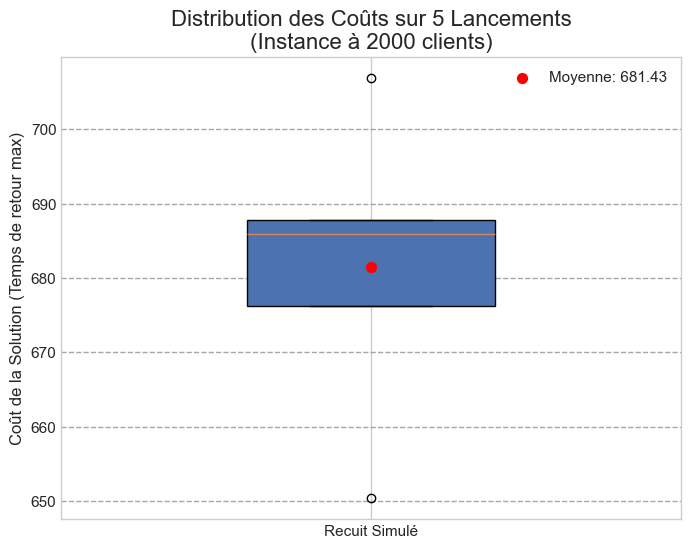

In [ ]:
for nb_clients, data in resultats_pour_graphiques.items():
    
    all_costs = data['costs']
    NB_LANCES = data['num_runs']

    # 1. Préparer les données en filtrant les solutions invalides
    couts_valides = [c for c in all_costs if c != float('inf')]

    # 2. Vérifier s'il y a des données à afficher
    if not couts_valides:
        print(f"\nInstance {nb_clients} clients: Aucune solution valide, impossible de générer le graphique.")
        continue # Passe à l'instance suivante
    
    # 3. Créer la figure et le graphique
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.boxplot(couts_valides, vert=True, patch_artist=True, widths=0.4)

    # 4. Améliorer l'affichage avec le bon nombre de clients dans le titre
    ax.set_title(f'Distribution des Coûts sur {NB_LANCES} Lancements\n(Instance à {nb_clients} clients)', fontsize=16)
    ax.set_ylabel('Coût de la Solution (Temps de retour max)', fontsize=12)
    ax.set_xticklabels(['Recuit Simulé'])
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)
    
    moyenne = np.mean(couts_valides)
    ax.scatter(1, moyenne, marker='o', color='red', s=50, zorder=3, label=f'Moyenne: {moyenne:.2f}')
    ax.legend()
    
    # 5. Afficher le graphique final pour cette instance
    plt.show()

# 7. Conclusion et Perspectives

Ce livrable établit la modélisation et la résolution d'un problème de tournées de véhicules dépendant du temps (TDVRP), au cœur des enjeux logistiques actuels et en réponse aux objectifs de l'ADEME pour une mobilité plus maîtrisée. Notre objectif n'était pas la simple minimisation de la distance, mais celle, plus complexe, du **makespan** (l'heure de retour du dernier véhicule), en intégrant les contraintes réelles d'une flotte thermique et d'un trafic dynamique.

## 7.1. Le Choix du Recuit Simulé face aux Algorithmes "Rapides"

Face à ce problème, il aurait été tentant d'opter pour un algorithme "rapide", telle qu'une heuristique gloutonne (ex: "plus proche voisin"). Si une telle méthode fournit une solution quasi instantanément, elle est structurellement limitée : elle se retrouve inévitablement "piégée" dans un **minimum local** – une solution qui *semble* bonne, mais qui est loin d'être optimale.

Notre problème étant **NP-difficile**, trouver la solution optimale garantie est informatiquement impossible pour 1000 clients. Nous avons donc délibérément choisi le **Recuit Simulé (SA)**. Cette métaheuristique représente un compromis stratégique entre temps de calcul et qualité de la solution.

La force du SA, et la raison de notre choix, est sa capacité à **échapper aux minimums locaux**. En s'autorisant, de manière contrôlée, à accepter temporairement des solutions dégradées (grâce au concept de "température"), l'algorithme explore une part bien plus vaste de l'espace de recherche. Il privilégie la **robustesse de la solution finale** à la vitesse d'exécution pure, ce qui est essentiel pour un problème logistique où chaque minute économisée sur le makespan a un impact opérationnel et écologique réel.

## 7.2. Analyse et Pistes d'Amélioration

Notre étude de stabilité, menée sur plusieurs lancements, a confirmé que le Recuit Simulé produit des solutions cohérentes et performantes. Les visualisations (boîtes à moustaches) montrent une distribution resserrée des coûts, indiquant que l'algorithme converge de manière fiable vers une bonne solution, malgré sa nature stochastique.

Ce modèle, bien que fonctionnel, constitue une fondation sur laquelle nous pouvons bâtir. Plusieurs axes d'amélioration sont identifiés pour la suite du projet :

1.  **Affinage des Hyperparamètres :** Les performances du SA (température, taux de refroidissement, itérations) ont été fixées pour cette étude. Une campagne de *tuning* plus poussée permettrait d'optimiser le rapport temps/qualité.
2.  **Opérateurs de Voisinage :** Nous utilisons des opérateurs de voisinage standards ('relocate', 'swap'). L'implémentation de mouvements plus complexes (ex: 2-opt, *cross-exchange*) pourrait permettre d'explorer l'espace de recherche de manière plus efficace et d'accélérer la convergence.
3.  **Enrichissement du Modèle (Objectif ADEME) :** La prochaine étape majeure est de complexifier le modèle pour refléter pleinement les ambitions de la mobilité multimodale. Cela inclut :
    * **Flotte Hétérogène :** Introduire différents types de véhicules (vélos-cargos, utilitaires légers).
    * **Véhicules Électriques (EVRP) :** Intégrer la gestion de l'autonomie et les contraintes de recharge, un défi majeur mais essentiel pour la décarbonation.
4.  **Modèle de Trafic Avancé :** Le trafic est actuellement modélisé par tranches fixes. Une évolution pourrait utiliser des modèles prédictifs basés sur des données historiques pour un calcul des temps de trajet encore plus réaliste.

En conclusion, ce livrable valide une approche robuste pour un problème complexe. Nous disposons désormais d'un socle algorithmique solide, capable de gérer des contraintes non linéaires, et prêt à être étendu pour intégrer les défis de la mobilité intelligente et durable.

# 7. Références bibliographiques

  * [Analyse de la complexité](https://fr.wikipedia.org/wiki/Analyse_de_la_complexit%C3%A9_des_algorithmes)
  * [Théorie des Graphes](https://fr.wikipedia.org/wiki/Th%C3%A9orie_des_graphes)
  * [Problème du voyageur de commerce](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce)
  * [P, NP et les classes](https://www.google.com/search?q=https://www.geeksforgeeks.org/dsa/types-of-complexity-classes-p-np-conp-np-hard-and-np-complete)
